# **NAMED ENTITY RECOGNITION (NER)**

In [ ]:
%pip install -q -r requirements.txt

In [1]:
import numpy as np
import spacy
import nltk
import svgling
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score

In [ ]:
# Function definitions

In [2]:
nltk.download('conll2002')
from nltk.corpus import conll2002

# Spanish
train_esp = conll2002.iob_sents('esp.train') # Train
val_esp = conll2002.iob_sents('esp.testa') # Val
test_esp = conll2002.iob_sents('esp.testb') # Test
# Dutch
train_ned = conll2002.iob_sents('ned.train') # Train
val_ned = conll2002.iob_sents('ned.testa') # Val
test_ned = conll2002.iob_sents('ned.testb') # Test

[nltk_data] Downloading package conll2002 to
[nltk_data]     C:\Users\Usuario\AppData\Roaming\nltk_data...
[nltk_data]   Package conll2002 is already up-to-date!


In [3]:
def get_tuples(X : list, method: str = 'bio') -> list[tuple[str, str]]:
    """
    Get tuples from the dataset.

    Parameters
    ----------
    X : list
        Dataset.
    method : str
        Method to get tuples. Options: 'bio', 'biow', 'io'. Default: 'bio'.

    Returns
    -------
    list
        List of tuples.
    """
    assert method.lower() in ['bio', 'biow', 'io'], "Method not valid, options: 'bio', 'biow', 'io'"
    
    new_X = []
    for sentence in X:
        tuple_sentence = []
        for idx, word in enumerate(sentence):    
            if method.lower() == 'bio':
                # By default
                tuple_sentence.append((word[0], word[2]))
            
            elif method.lower() == 'biow':
                # When there is a B-TAG and the next word is an O-TAG, the B-TAG is changed to an W-TAG (length 1)
                if word[2].startswith('B') and (idx+1) < len(sentence) and sentence[idx+1][2].startswith('O'):
                    tuple_sentence.append((word[0], f'W-{word[2][2:]}'))
                else:
                    tuple_sentence.append((word[0], word[2]))
            
            elif method.lower() == 'io':
                # When there is a B-TAG, it is changed to an I-TAG
                if word[2].startswith('B'):
                    tuple_sentence.append((word[0], f'I-{word[2][2:]}'))
                else:
                    tuple_sentence.append((word[0], word[2]))
    
        new_X.append(tuple_sentence)
    
    return new_X

In [4]:
train_esp_tuples = get_tuples(train_esp)
train_ned_tuples = get_tuples(train_ned)
val_esp_tuples = get_tuples(val_esp)
val_ned_tuples = get_tuples(val_ned)
test_esp_tuples = get_tuples(test_esp)
test_ned_tuples = get_tuples(test_ned)

In [5]:
tagger_esp = nltk.tag.CRFTagger()
tagger_ned = nltk.tag.CRFTagger()

In [6]:
tagger_esp.train(train_esp_tuples, model_file='./models/model_base_esp.mdl')
tagger_ned.train(train_ned_tuples, model_file='./models/model_base_ned.mdl')

In [13]:
test_data_es_tolist = [[token for token, _ in sentence] for sentence in test_esp_tuples]
test_data_nl_tolist = [[token for token, _ in sentence] for sentence in test_ned_tuples]


from typing import List, Tuple, Set, Any

def decode_entities(phrase: List[Tuple[Any, str]]) -> Set[Tuple[int, int, str]]:
    first_idx = -1
    current_entity = None
    
    result = set()
    for i, (token, label) in enumerate(phrase):
        if label[0] == "B" or label == "O":
            if current_entity:
                result.add((first_idx, i, current_entity))
                current_entity = None
            if label[0] == "B":
                first_idx = i
                current_entity = label[2:]
    if current_entity:
        result.add((first_idx, len(phrase), current_entity))
    return result



tagged_es = []
for sentence in test_data_es_tolist:
    tagged_sentence = tagger_esp.tag(sentence)
    tagged_es.append(tagged_sentence)
    #decoded_es.append(decode_entities(tagged_sentence))

tagged_nl = []
for sentence in test_data_nl_tolist:
    tagged_sentence = tagger_ned.tag(sentence)
    tagged_nl.append(tagged_sentence)
    #decoded_nl.append(decode_entities(tagged_sentence))
    
    


In [14]:
def evaluate(gold: List[List[Tuple[Any, str]]], predicted: List[List[Tuple[Any, str]]]) -> Tuple[int, int, int]:
    tp = 0
    fn = 0
    fp = 0
    tot = 0
    err = 0
    for idx, (gold_sentence, predicted_sentence) in enumerate(zip(gold, predicted)):
        gold_entities = decode_entities(gold_sentence)
        predicted_entities = decode_entities(predicted_sentence)
        tp += len(gold_entities.intersection(predicted_entities))
        fn += len(gold_entities.difference(predicted_entities))
        fp += len(predicted_entities.difference(gold_entities))
        #tot += len(gold_entities.union(predicted_entities))

        if gold_entities != predicted_entities:
            print("Sentence index:", idx)
            print("GOLD sentence: ", gold_sentence)
            print("PRED sentence: ", predicted_sentence)
            for i in range(len(gold_sentence)):
                if gold_sentence[i][1] != predicted_sentence[i][1]:
                    print(f"ERROR {i} --- Gold: {gold_sentence[i]} Predicted: {predicted_sentence[i]}")
                    err += 1
                tot += 1
            print()

    return tp, fn, fp, tot, err

tp_es, fn_es, fp_es, tot_es, err_es = evaluate(test_esp_tuples, tagged_es)
tp_nl, fn_nl, fp_nl, tot_nl, err_nl = evaluate(test_ned_tuples, tagged_nl)

Sentence index: 2
GOLD sentence:  [('Las', 'O'), ('reservas', 'O'), ('"', 'O'), ('on', 'O'), ('line', 'O'), ('"', 'O'), ('de', 'O'), ('billetes', 'O'), ('aéreos', 'O'), ('a', 'O'), ('través', 'O'), ('de', 'O'), ('Internet', 'B-MISC'), ('aumentaron', 'O'), ('en', 'O'), ('España', 'B-LOC'), ('un', 'O'), ('300', 'O'), ('por', 'O'), ('ciento', 'O'), ('en', 'O'), ('el', 'O'), ('primer', 'O'), ('trimestre', 'O'), ('de', 'O'), ('este', 'O'), ('año', 'O'), ('con', 'O'), ('respecto', 'O'), ('al', 'O'), ('mismo', 'O'), ('período', 'O'), ('de', 'O'), ('1999', 'O'), (',', 'O'), ('aseguró', 'O'), ('hoy', 'O'), ('Iñigo', 'B-PER'), ('García', 'I-PER'), ('Aranda', 'I-PER'), (',', 'O'), ('responsable', 'O'), ('de', 'O'), ('comunicación', 'O'), ('de', 'O'), ('Savia', 'B-ORG'), ('Amadeus', 'I-ORG'), ('.', 'O')]
PRED sentence:  [('Las', 'O'), ('reservas', 'O'), ('"', 'O'), ('on', 'O'), ('line', 'O'), ('"', 'O'), ('de', 'O'), ('billetes', 'O'), ('aéreos', 'O'), ('a', 'O'), ('través', 'O'), ('de', 'O'), ('I

In [15]:
def calculate_precision_recall_f1(tp, fn, fp):
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1_score = 2 * (precision * recall) / (precision + recall)
    return precision, recall, f1_score

precision_es, recall_es, f1_es = calculate_precision_recall_f1(tp_es, fn_es, fp_es)
precision_nl, recall_nl, f1_nl = calculate_precision_recall_f1(tp_nl, fn_nl, fp_nl)

print("Spanish:")
print("Precision:", precision_es)
print("Recall:", recall_es)
print("F1-score:", f1_es)
print("Total errors:", err_es)
print()
print("Dutch:")
print("Precision:", precision_nl)
print("Recall:", recall_nl)
print("F1-score:", f1_nl)
print("Total errors:", err_nl)


Spanish:
Precision: 0.7413184226015304
Recall: 0.707982012366498
F1-score: 0.724266820011501
Total errors: 1935

Dutch:
Precision: 0.700915855752719
Recall: 0.6214158842933266
F1-score: 0.6587760591795563
Total errors: 2343


In [18]:
tagger_esp.accuracy(test_esp_tuples)

0.9622960045019696

In [19]:
tagger_ned.accuracy(test_ned_tuples)

0.9659818511796733

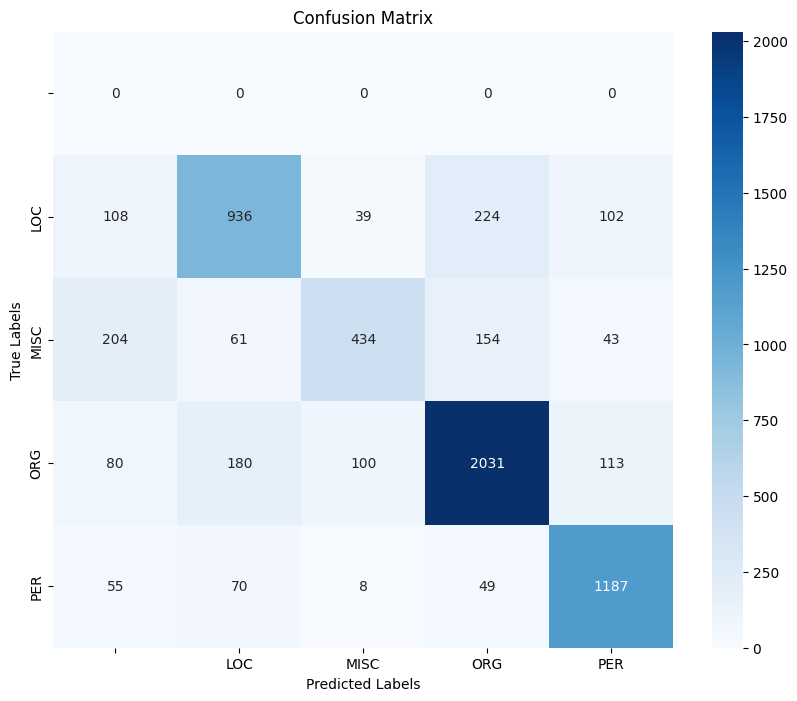

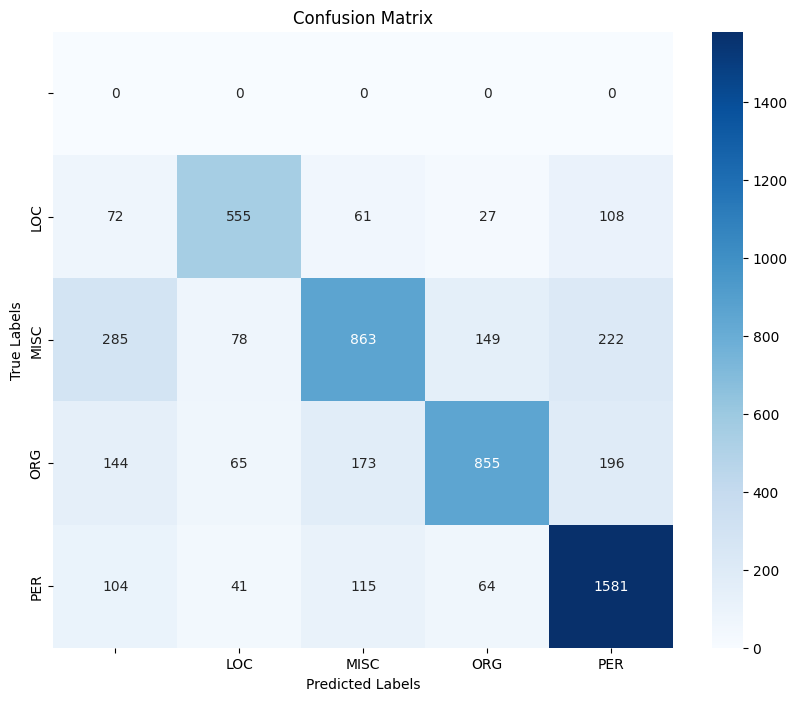

In [20]:
from collections import defaultdict
from typing import Dict
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def confusion_matrix(gold: List[List[Tuple[Any, str]]], predicted: List[List[Tuple[Any, str]]]) -> Dict[Tuple[str, str], int]:
    # Initialize confusion matrix
    matrix = defaultdict(int)

    # Iterate through each sentence
    for gold_sentence, predicted_sentence in zip(gold, predicted):

        # Update confusion matrix
        for gold_token, predicted_token in zip(gold_sentence, predicted_sentence):
            if gold_token[1] != 'O':
                matrix[(gold_token[1][2:], predicted_token[1][2:])] += 1
    # Extract unique entity types
    matrix_dict = matrix
    unique_labels = sorted(set(label for pair in matrix_dict.keys() for label in pair))

    # Create an empty matrix
    matrix = np.zeros((len(unique_labels), len(unique_labels)))

    # Fill the matrix with counts
    for i, label1 in enumerate(unique_labels):
        for j, label2 in enumerate(unique_labels):
            matrix[i, j] = matrix_dict.get((label1, label2), 0)

    # Create a heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(matrix, annot=True, fmt='g', cmap='Blues', xticklabels=unique_labels, yticklabels=unique_labels)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()
    return matrix_dict

# Generate confusion matrix for Spanish data
confusion_matrix_es = confusion_matrix(test_esp_tuples, tagged_es)

# Generate confusion matrix for Dutch data
confusion_matrix_nl = confusion_matrix(test_ned_tuples, tagged_nl)
